In [1]:
import prepare_data
from aug_torchdataset import SegmentationDataset, get_train_augs, get_valid_augs, get_test_augs
from utils import train_fn, visualize_sample, plot_loss
from model import SegmentationModel
from evaluation import evaluate_metrics
from active_learning import active_learning_loop
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import os

/home/stu4/s8/mc6044/miniconda3/envs/idai780/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="16"

In [28]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 50
LR = 0.001
IMAGE_SIZE = 256
BATCH_SIZE = 16

ENCODER = 'efficientnet-b4'
WEIGHTS = 'imagenet'

EPOCHS_AL_INITIAL = 30
al_budget_per_iter = 50
al_max_iterations =15
al_epochs_per_iter = 2
al_n_show

In [4]:
base_dir = "Capstone"

zip_path = f"./{base_dir}/KolektorSDD2.zip"
extract_path=f"./{base_dir}/"

train_images_path = f"./{base_dir}/train_images"
train_masks_path = f"./{base_dir}/train_masks"
test_images_path = f"./{base_dir}/test_images"
test_masks_path = f"./{base_dir}/test_masks"

train_csv = f"./{base_dir}/train_data.csv"
test_csv = f"./{base_dir}/test_data.csv"

os.makedirs(f"./{base_dir}/model", exist_ok=True)
os.makedirs(f"./{base_dir}/figure", exist_ok=True)
os.makedirs(f"./{base_dir}/results", exist_ok=True)

In [5]:
# extract_zip(zip_path = zip_path, extract_path=f"./{base_dir}/")
# organize_files(base_dir = f"./{base_dir}/")
# create_csv("./data/train_images", "./data/train_masks", "./data/train_data.csv")
# create_csv("./data/test_images", "./data/test_masks", "./data/test_data.csv")

In [6]:
df_train_full = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)
train_df_labelled, train_df_unlabelled = train_test_split(df_train_full, test_size=0.5)

print(f'Total Train Data: {len(df_train_full)}\n')
print(f'Unlablled Train Data for Active Learning: {len(train_df_unlabelled)}')
print(f'Lablled Train Data for Active Learning: {len(train_df_labelled)}\n')
print(f'Total Test Data: {len(test_df)}')

Total Train Data: 2331

Unlablled Train Data for Active Learning: 1166
Lablled Train Data for Active Learning: 1165

Total Test Data: 1004


Shape of Image: (645, 229, 3) & Shape of Mask: (645, 229)



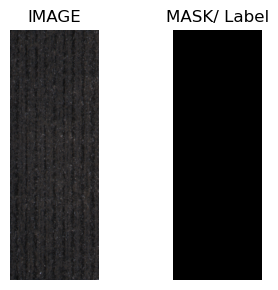

In [7]:
visualize_sample(df_train_full, 0)

In [8]:
full_trainset = SegmentationDataset(df_train_full, get_train_augs())
labelled_trainset = SegmentationDataset(train_df_labelled, get_train_augs())
unlabelled_trainset = SegmentationDataset(train_df_unlabelled, get_valid_augs())
testset = SegmentationDataset(test_df, get_test_augs())

In [9]:
full_trainloader = DataLoader(full_trainset, batch_size=BATCH_SIZE, shuffle=True)
labelled_trainloader = DataLoader(labelled_trainset, batch_size=BATCH_SIZE)
unlabelled_trainloader = DataLoader(unlabelled_trainset, batch_size=BATCH_SIZE)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

In [10]:
for image, mask in full_trainloader:
  break
print(f"one batch image shape : {image.shape}")
print(f"one batch mask shape : {mask.shape}") 

one batch image shape : torch.Size([16, 3, 256, 256])
one batch mask shape : torch.Size([16, 1, 256, 256])


In [11]:
baseline_model = SegmentationModel()
baseline_model.to(DEVICE);
optimizer = optim.Adam(baseline_model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [12]:
train_losses_baseline = []

print("Training baseline model on full training data...")
for i in range(EPOCHS):
    train_loss = train_fn(full_trainloader, baseline_model, optimizer)
    train_losses_baseline.append(train_loss)
    scheduler.step(train_loss)
    
    # Optional: Print current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {i+1}: Train Loss: {train_loss:.4f}, Learning Rate: {current_lr:.6f}")

# Save the model after all epochs are complete using base_dir
model_save_path_baseline = f"./{base_dir}/model/baseline_model.pt"
torch.save(baseline_model.state_dict(), model_save_path_baseline)
print("Model saved after training completion")

Training baseline model on full training data...


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:25<00:00,  1.00it/s]


Epoch 1: Train Loss: 0.7071, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 2: Train Loss: 0.4089, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 3: Train Loss: 0.3700, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 4: Train Loss: 0.3731, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 5: Train Loss: 0.3521, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 6: Train Loss: 0.3571, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:25<00:00,  1.01it/s]


Epoch 7: Train Loss: 0.3385, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:25<00:00,  1.01it/s]


Epoch 8: Train Loss: 0.3199, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 9: Train Loss: 0.3320, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:25<00:00,  1.01it/s]


Epoch 10: Train Loss: 0.3382, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 11: Train Loss: 0.2981, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 12: Train Loss: 0.3057, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 13: Train Loss: 0.3125, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 14: Train Loss: 0.3000, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 15: Train Loss: 0.2837, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 16: Train Loss: 0.3189, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 17: Train Loss: 0.2802, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 18: Train Loss: 0.2734, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:25<00:00,  1.00it/s]


Epoch 19: Train Loss: 0.2794, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 20: Train Loss: 0.2840, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 21: Train Loss: 0.2994, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 22: Train Loss: 0.2417, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 23: Train Loss: 0.2557, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 24: Train Loss: 0.2471, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 25: Train Loss: 0.2657, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 26: Train Loss: 0.2613, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 27: Train Loss: 0.2449, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 28: Train Loss: 0.2365, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 29: Train Loss: 0.2797, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 30: Train Loss: 0.2631, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 31: Train Loss: 0.2532, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 32: Train Loss: 0.2462, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 33: Train Loss: 0.2555, Learning Rate: 0.001000


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:23<00:00,  1.01it/s]


Epoch 34: Train Loss: 0.2379, Learning Rate: 0.000100


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 35: Train Loss: 0.2283, Learning Rate: 0.000100


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 36: Train Loss: 0.2169, Learning Rate: 0.000100


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 37: Train Loss: 0.2173, Learning Rate: 0.000100


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 38: Train Loss: 0.2543, Learning Rate: 0.000100


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 39: Train Loss: 0.2331, Learning Rate: 0.000100


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 40: Train Loss: 0.2085, Learning Rate: 0.000100


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 41: Train Loss: 0.2290, Learning Rate: 0.000100


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 42: Train Loss: 0.2112, Learning Rate: 0.000100


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 43: Train Loss: 0.2375, Learning Rate: 0.000100


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 44: Train Loss: 0.2256, Learning Rate: 0.000100


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 45: Train Loss: 0.2115, Learning Rate: 0.000100


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 46: Train Loss: 0.2180, Learning Rate: 0.000010


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 47: Train Loss: 0.2371, Learning Rate: 0.000010


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 48: Train Loss: 0.2294, Learning Rate: 0.000010


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:24<00:00,  1.01it/s]


Epoch 49: Train Loss: 0.2150, Learning Rate: 0.000010


100%|█████████████████████████████████████████████████████████████████████████████████| 146/146 [02:23<00:00,  1.01it/s]


Epoch 50: Train Loss: 0.2242, Learning Rate: 0.000010
Model saved after training completion


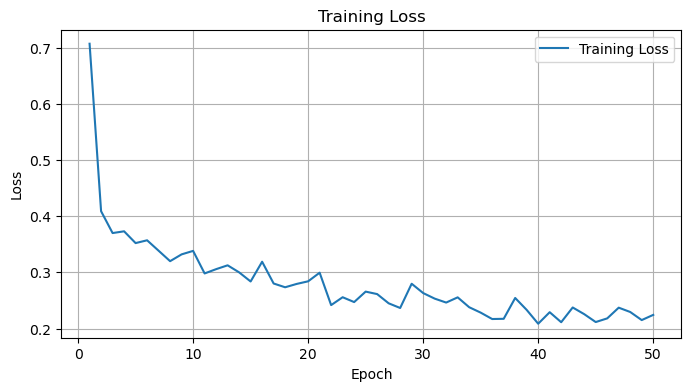

In [13]:
figure_save_path = f"./{base_dir}/figure/baseline_model_loss.jpg"
plot_loss(train_losses_baseline, save_path = figure_save_path)

In [14]:
baseline_metrics = evaluate_metrics(testloader, baseline_model);

100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:21<00:00,  2.88it/s]


Model Evaluation Metrics:
------------------------------
Metric            Value
------------------------------
IoU              0.6634
Dice             0.7576
Accuracy         0.9989
Precision        0.8593
Recall           0.7624
------------------------------


In [15]:
al_model_initial = SegmentationModel()
al_model_initial.to(DEVICE)
optimizer = optim.Adam(al_model_initial.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [16]:
train_losses_al_initial = []

print("Training baseline model on full training data...")
for i in range(EPOCHS_AL_INITIAL):
    train_loss = train_fn(labelled_trainloader, al_model_initial, optimizer)
    train_losses_al_initial.append(train_loss)
    scheduler.step(train_loss)
    
    # Optional: Print current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {i+1}: Train Loss: {train_loss:.4f}, Learning Rate: {current_lr:.6f}")

# Save the model after all epochs are complete using base_dir
model_save_path_al_initial = f"./{base_dir}/model/al_model_initial.pt"
torch.save(al_model_initial.state_dict(), model_save_path_al_initial)

Training baseline model on full training data...


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 1: Train Loss: 0.8321, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 2: Train Loss: 0.5633, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 3: Train Loss: 0.4038, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 4: Train Loss: 0.3817, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 5: Train Loss: 0.3993, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 6: Train Loss: 0.3683, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 7: Train Loss: 0.3592, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 8: Train Loss: 0.3493, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 9: Train Loss: 0.3529, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 10: Train Loss: 0.3406, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 11: Train Loss: 0.3531, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 12: Train Loss: 0.3306, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 13: Train Loss: 0.2780, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 14: Train Loss: 0.3037, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 15: Train Loss: 0.3252, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 16: Train Loss: 0.3019, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 17: Train Loss: 0.2870, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 18: Train Loss: 0.2854, Learning Rate: 0.001000


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 19: Train Loss: 0.2905, Learning Rate: 0.000100


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 20: Train Loss: 0.2536, Learning Rate: 0.000100


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 21: Train Loss: 0.2368, Learning Rate: 0.000100


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 22: Train Loss: 0.2527, Learning Rate: 0.000100


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 23: Train Loss: 0.2421, Learning Rate: 0.000100


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 24: Train Loss: 0.2300, Learning Rate: 0.000100


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 25: Train Loss: 0.2201, Learning Rate: 0.000100


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 26: Train Loss: 0.2389, Learning Rate: 0.000100


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 27: Train Loss: 0.2170, Learning Rate: 0.000100


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 28: Train Loss: 0.1964, Learning Rate: 0.000100


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 29: Train Loss: 0.2141, Learning Rate: 0.000100


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:12<00:00,  1.01it/s]


Epoch 30: Train Loss: 0.2131, Learning Rate: 0.000100


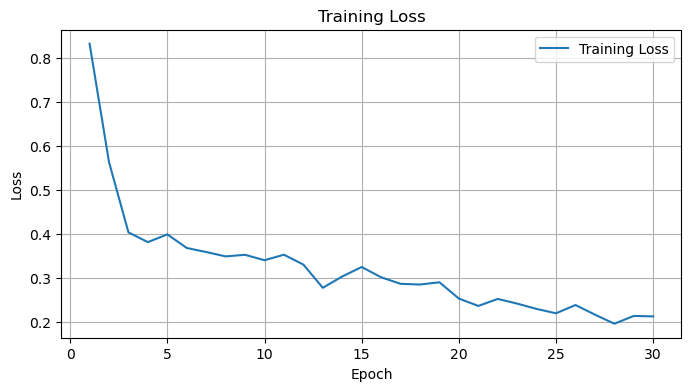

In [17]:
figure_save_path = f"./{base_dir}/figure/al_initial_model_loss.jpg"
plot_loss(train_losses_al_initial, save_path = figure_save_path)


Active Learning Iteration 1/15


Computing uncertainties: 100%|██████████████████████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



Displaying top 1 samples with highest uncertainty:


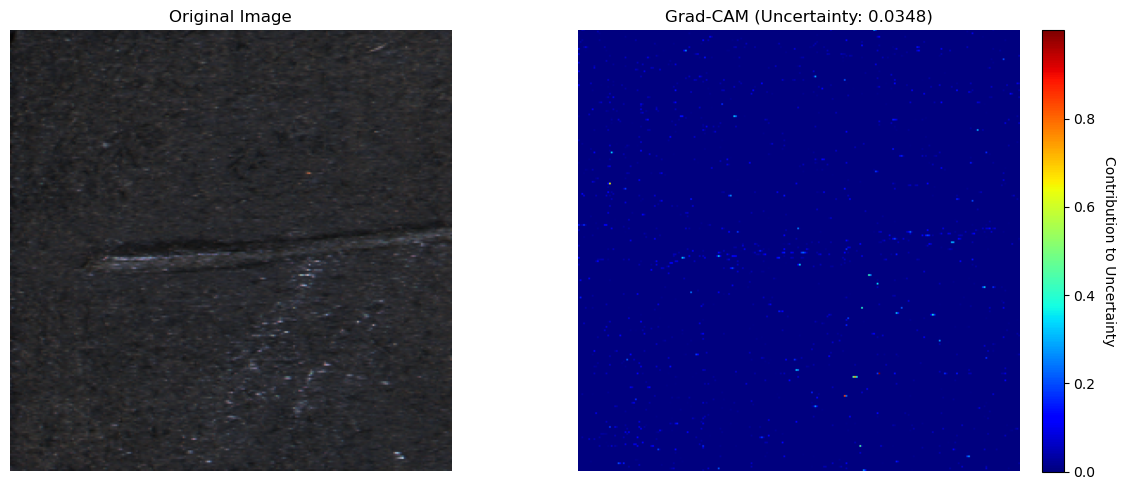

Selected 50 samples for labeling.


100%|███████████████████████████████████████████████████████████████████████████████████| 76/76 [01:15<00:00,  1.00it/s]


Iteration 1, Epoch 1/2 - Train Loss: 0.2852


100%|███████████████████████████████████████████████████████████████████████████████████| 76/76 [01:15<00:00,  1.01it/s]


Iteration 1, Epoch 2/2 - Train Loss: 0.2964

Active Learning Iteration 2/15


Computing uncertainties: 100%|██████████████████████████████████████████████████████████| 70/70 [00:24<00:00,  2.82it/s]



Displaying top 1 samples with highest uncertainty:


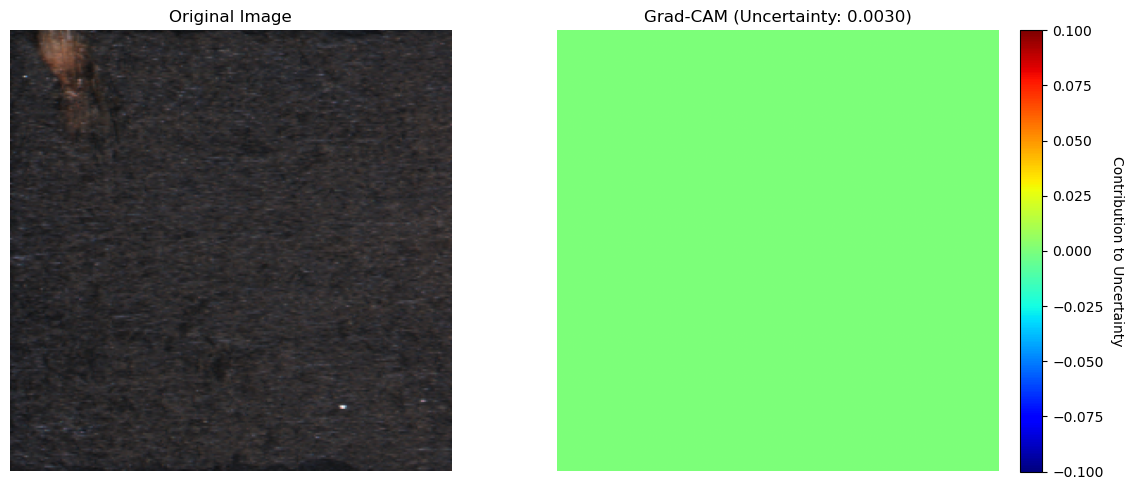

Selected 50 samples for labeling.


100%|███████████████████████████████████████████████████████████████████████████████████| 80/80 [01:18<00:00,  1.02it/s]


Iteration 2, Epoch 1/2 - Train Loss: 0.2974


100%|███████████████████████████████████████████████████████████████████████████████████| 80/80 [01:18<00:00,  1.02it/s]


Iteration 2, Epoch 2/2 - Train Loss: 0.2964

Active Learning Iteration 3/15


Computing uncertainties: 100%|██████████████████████████████████████████████████████████| 67/67 [00:23<00:00,  2.83it/s]



Displaying top 1 samples with highest uncertainty:


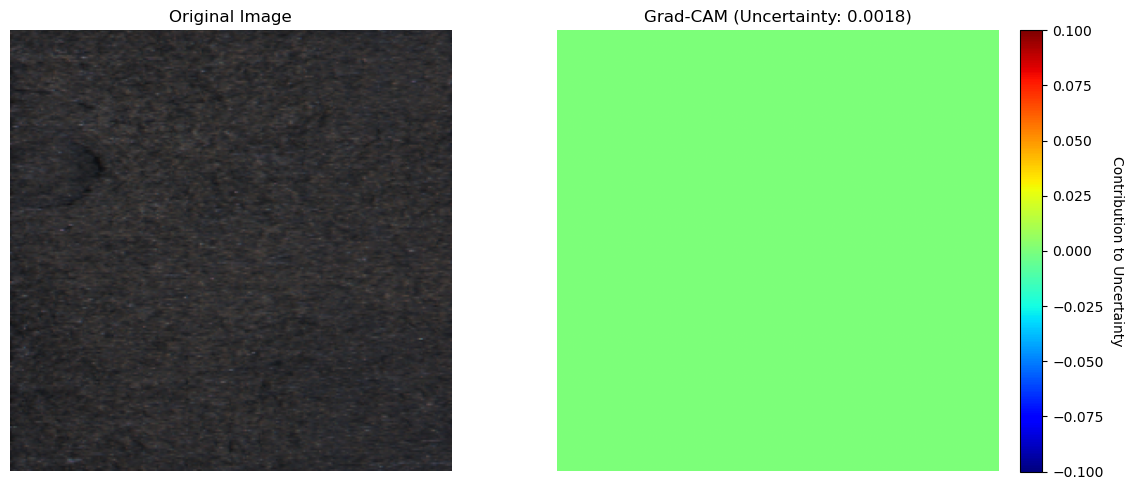

Selected 50 samples for labeling.


100%|███████████████████████████████████████████████████████████████████████████████████| 83/83 [01:21<00:00,  1.02it/s]


Iteration 3, Epoch 1/2 - Train Loss: 0.2882


100%|███████████████████████████████████████████████████████████████████████████████████| 83/83 [01:21<00:00,  1.02it/s]


Iteration 3, Epoch 2/2 - Train Loss: 0.2673

Active Learning Iteration 4/15


Computing uncertainties: 100%|██████████████████████████████████████████████████████████| 64/64 [00:22<00:00,  2.83it/s]



Displaying top 1 samples with highest uncertainty:


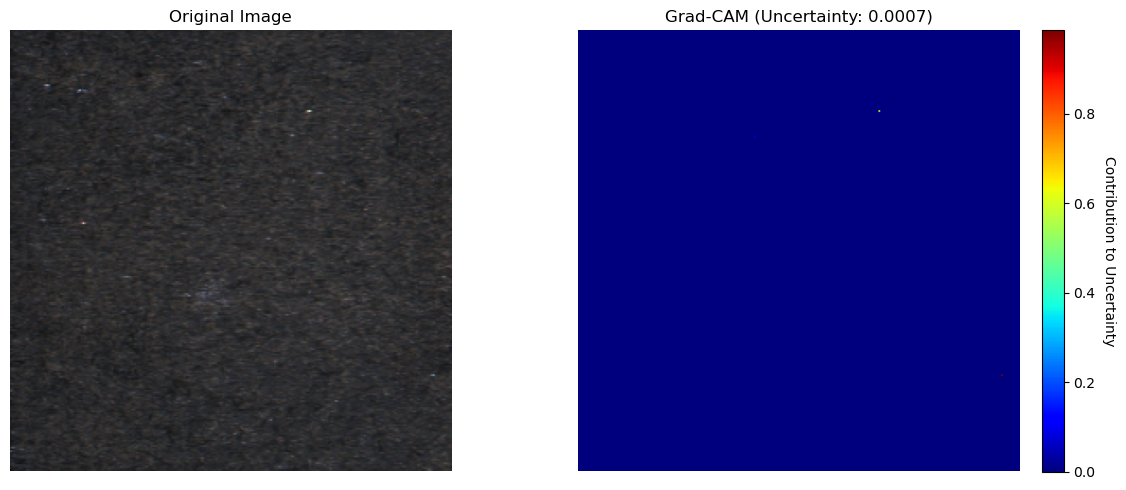

Selected 50 samples for labeling.


100%|███████████████████████████████████████████████████████████████████████████████████| 86/86 [01:24<00:00,  1.02it/s]


Iteration 4, Epoch 1/2 - Train Loss: 0.2580


100%|███████████████████████████████████████████████████████████████████████████████████| 86/86 [01:24<00:00,  1.02it/s]


Iteration 4, Epoch 2/2 - Train Loss: 0.2949

Active Learning Iteration 5/15


Computing uncertainties: 100%|██████████████████████████████████████████████████████████| 61/61 [00:21<00:00,  2.88it/s]



Displaying top 1 samples with highest uncertainty:


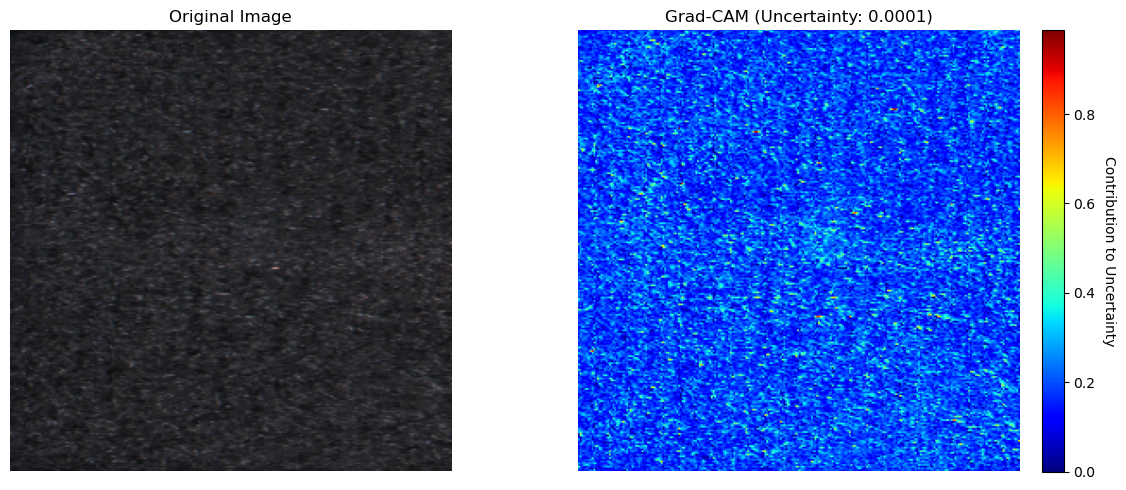

Selected 50 samples for labeling.


100%|███████████████████████████████████████████████████████████████████████████████████| 89/89 [01:27<00:00,  1.02it/s]


Iteration 5, Epoch 1/2 - Train Loss: 0.2594


100%|███████████████████████████████████████████████████████████████████████████████████| 89/89 [01:27<00:00,  1.02it/s]


Iteration 5, Epoch 2/2 - Train Loss: 0.2505

Active Learning Iteration 6/15


Computing uncertainties: 100%|██████████████████████████████████████████████████████████| 58/58 [00:20<00:00,  2.89it/s]



Displaying top 1 samples with highest uncertainty:


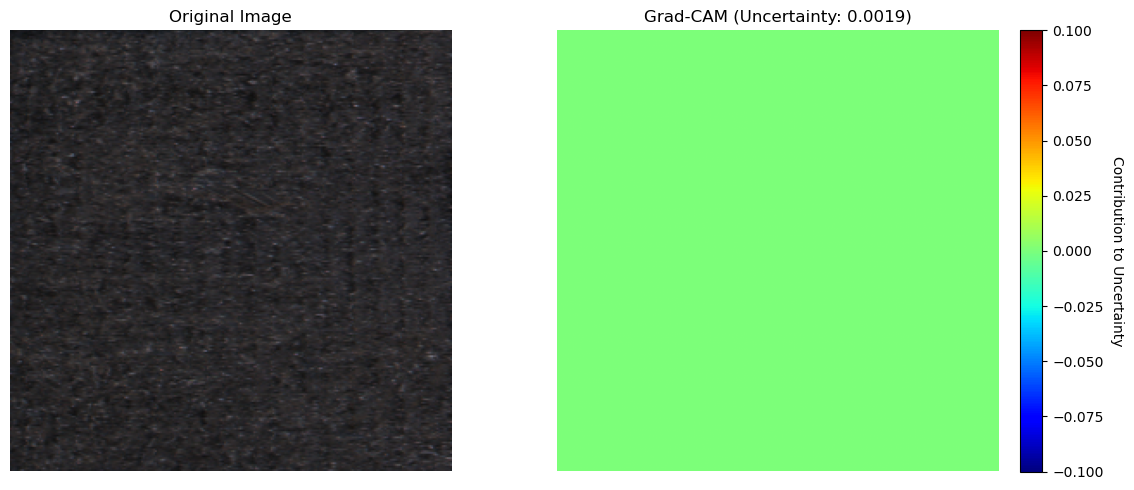

Selected 50 samples for labeling.


100%|███████████████████████████████████████████████████████████████████████████████████| 92/92 [01:30<00:00,  1.01it/s]


Iteration 6, Epoch 1/2 - Train Loss: 0.2730


100%|███████████████████████████████████████████████████████████████████████████████████| 92/92 [01:30<00:00,  1.02it/s]


Iteration 6, Epoch 2/2 - Train Loss: 0.2591

Active Learning Iteration 7/15


Computing uncertainties: 100%|██████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]



Displaying top 1 samples with highest uncertainty:


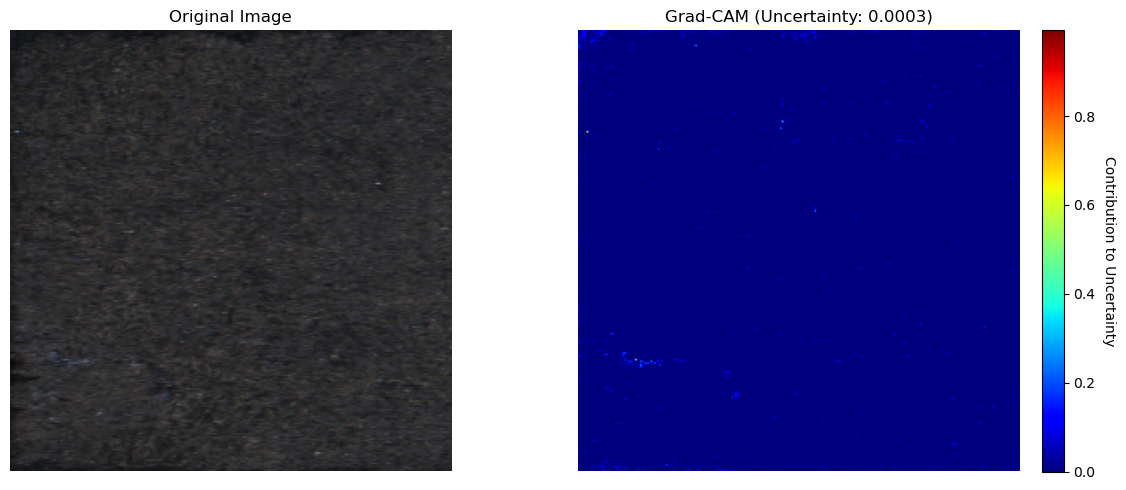

Selected 50 samples for labeling.


100%|███████████████████████████████████████████████████████████████████████████████████| 95/95 [01:34<00:00,  1.01it/s]


Iteration 7, Epoch 1/2 - Train Loss: 0.2458


100%|███████████████████████████████████████████████████████████████████████████████████| 95/95 [01:33<00:00,  1.01it/s]


Iteration 7, Epoch 2/2 - Train Loss: 0.2496

Active Learning Iteration 8/15


Computing uncertainties: 100%|██████████████████████████████████████████████████████████| 51/51 [00:17<00:00,  2.92it/s]



Displaying top 1 samples with highest uncertainty:


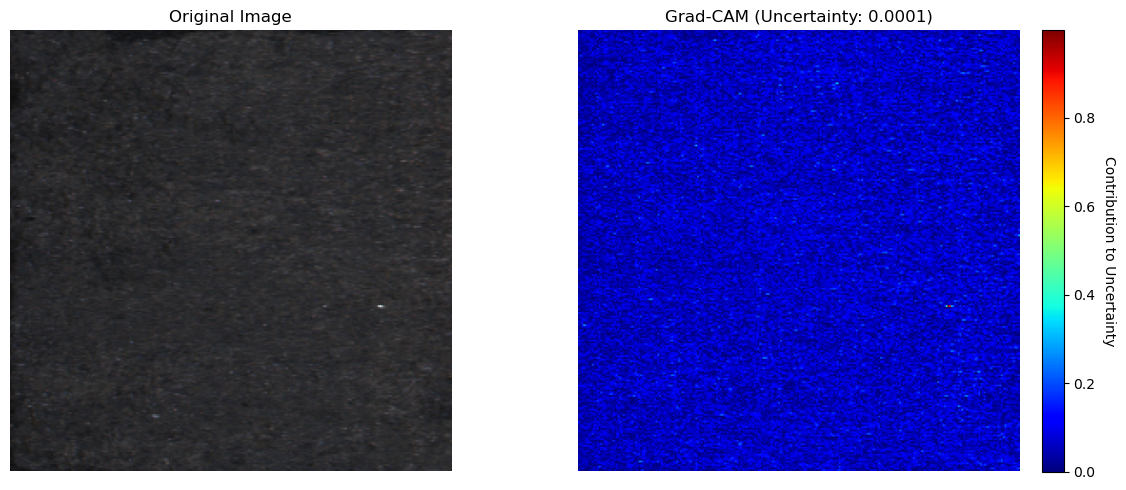

Selected 50 samples for labeling.


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [01:36<00:00,  1.01it/s]


Iteration 8, Epoch 1/2 - Train Loss: 0.2643


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [01:37<00:00,  1.01it/s]


Iteration 8, Epoch 2/2 - Train Loss: 0.2430

Active Learning Iteration 9/15


Computing uncertainties: 100%|██████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.89it/s]



Displaying top 1 samples with highest uncertainty:


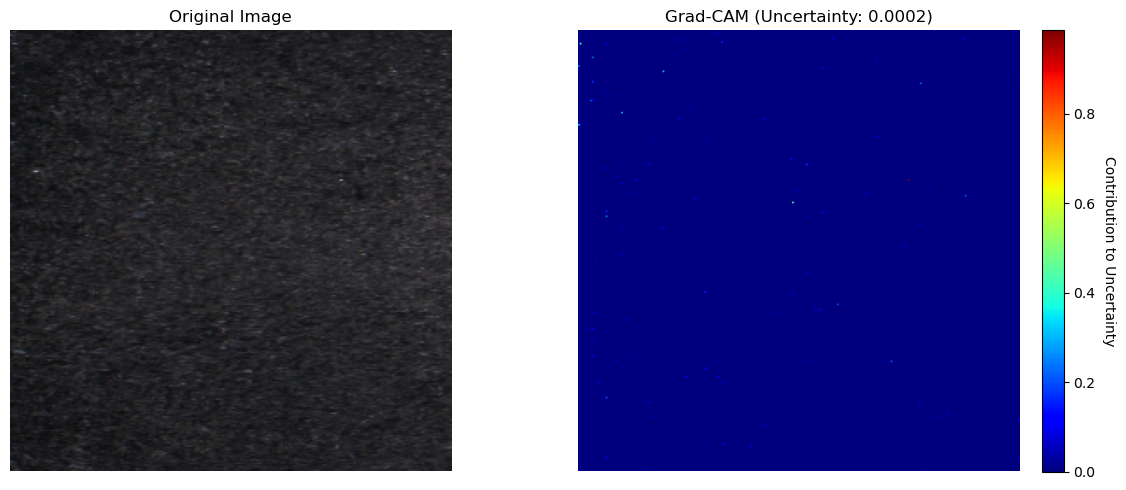

Selected 50 samples for labeling.


100%|█████████████████████████████████████████████████████████████████████████████████| 101/101 [01:40<00:00,  1.00it/s]


Iteration 9, Epoch 1/2 - Train Loss: 0.2724


100%|█████████████████████████████████████████████████████████████████████████████████| 101/101 [01:40<00:00,  1.01it/s]


Iteration 9, Epoch 2/2 - Train Loss: 0.2719

Active Learning Iteration 10/15


Computing uncertainties: 100%|██████████████████████████████████████████████████████████| 45/45 [00:15<00:00,  2.85it/s]



Displaying top 1 samples with highest uncertainty:


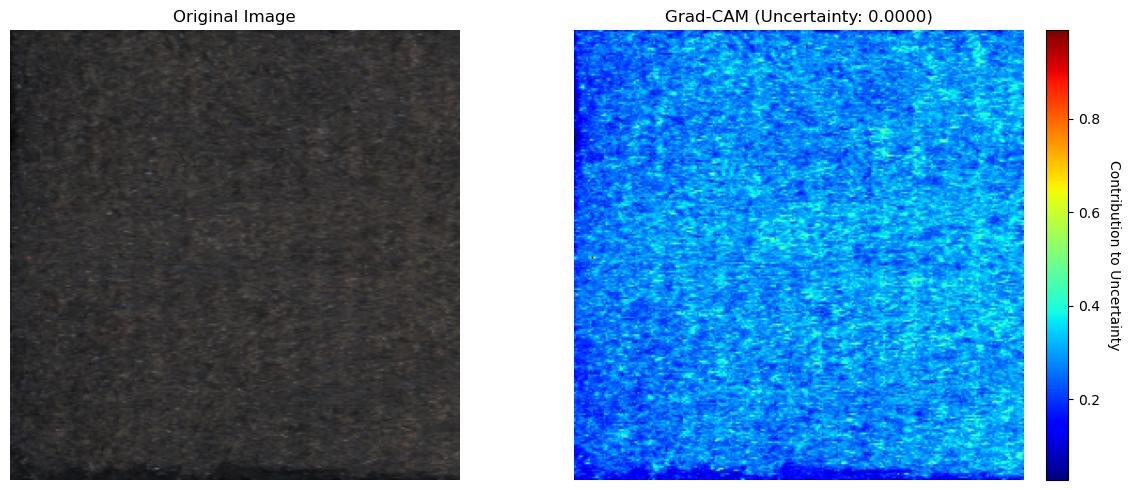

Selected 50 samples for labeling.


100%|█████████████████████████████████████████████████████████████████████████████████| 105/105 [01:43<00:00,  1.02it/s]


Iteration 10, Epoch 1/2 - Train Loss: 0.2816


100%|█████████████████████████████████████████████████████████████████████████████████| 105/105 [01:43<00:00,  1.01it/s]


Iteration 10, Epoch 2/2 - Train Loss: 0.2398

Active Learning Iteration 11/15


Computing uncertainties: 100%|██████████████████████████████████████████████████████████| 42/42 [00:14<00:00,  2.83it/s]



Displaying top 1 samples with highest uncertainty:


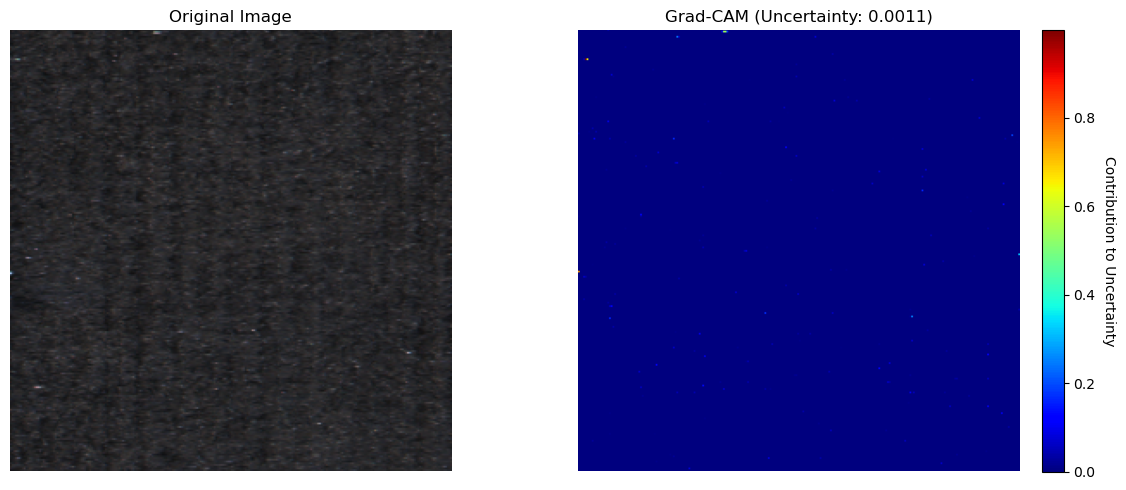

Selected 50 samples for labeling.


100%|█████████████████████████████████████████████████████████████████████████████████| 108/108 [01:46<00:00,  1.01it/s]


Iteration 11, Epoch 1/2 - Train Loss: 0.2322


100%|█████████████████████████████████████████████████████████████████████████████████| 108/108 [01:46<00:00,  1.01it/s]


Iteration 11, Epoch 2/2 - Train Loss: 0.2346

Active Learning Iteration 12/15


Computing uncertainties: 100%|██████████████████████████████████████████████████████████| 39/39 [00:13<00:00,  2.84it/s]



Displaying top 1 samples with highest uncertainty:


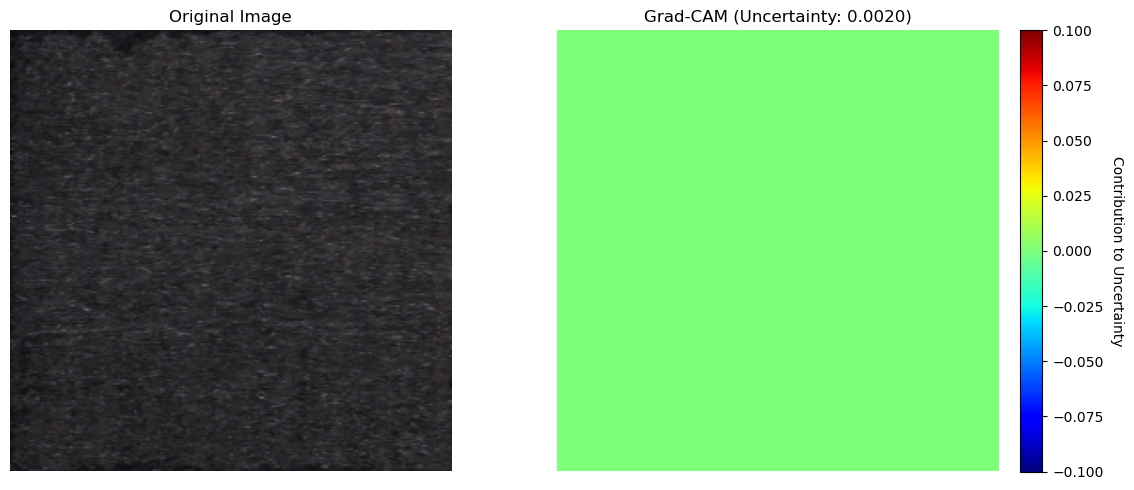

Selected 50 samples for labeling.


100%|█████████████████████████████████████████████████████████████████████████████████| 111/111 [01:49<00:00,  1.01it/s]


Iteration 12, Epoch 1/2 - Train Loss: 0.2136


100%|█████████████████████████████████████████████████████████████████████████████████| 111/111 [01:49<00:00,  1.01it/s]


Iteration 12, Epoch 2/2 - Train Loss: 0.2386

Active Learning Iteration 13/15


Computing uncertainties: 100%|██████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.90it/s]



Displaying top 1 samples with highest uncertainty:


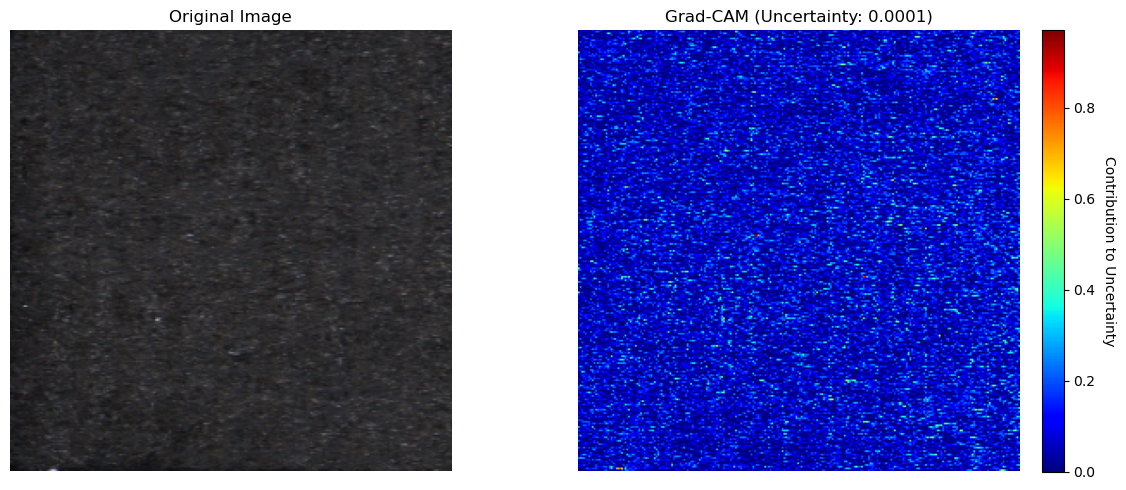

Selected 50 samples for labeling.


100%|█████████████████████████████████████████████████████████████████████████████████| 114/114 [01:52<00:00,  1.01it/s]


Iteration 13, Epoch 1/2 - Train Loss: 0.2471


100%|█████████████████████████████████████████████████████████████████████████████████| 114/114 [01:52<00:00,  1.01it/s]


Iteration 13, Epoch 2/2 - Train Loss: 0.2599

Active Learning Iteration 14/15


Computing uncertainties: 100%|██████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.79it/s]



Displaying top 1 samples with highest uncertainty:


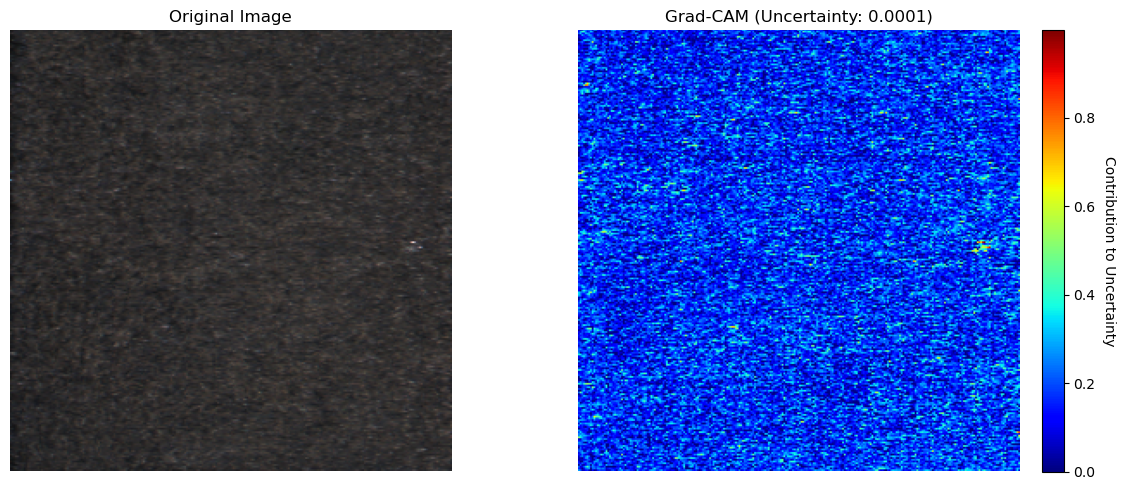

Selected 50 samples for labeling.


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [01:55<00:00,  1.01it/s]


Iteration 14, Epoch 1/2 - Train Loss: 0.2424


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [01:55<00:00,  1.01it/s]


Iteration 14, Epoch 2/2 - Train Loss: 0.2701

Active Learning Iteration 15/15


Computing uncertainties: 100%|██████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.91it/s]



Displaying top 1 samples with highest uncertainty:


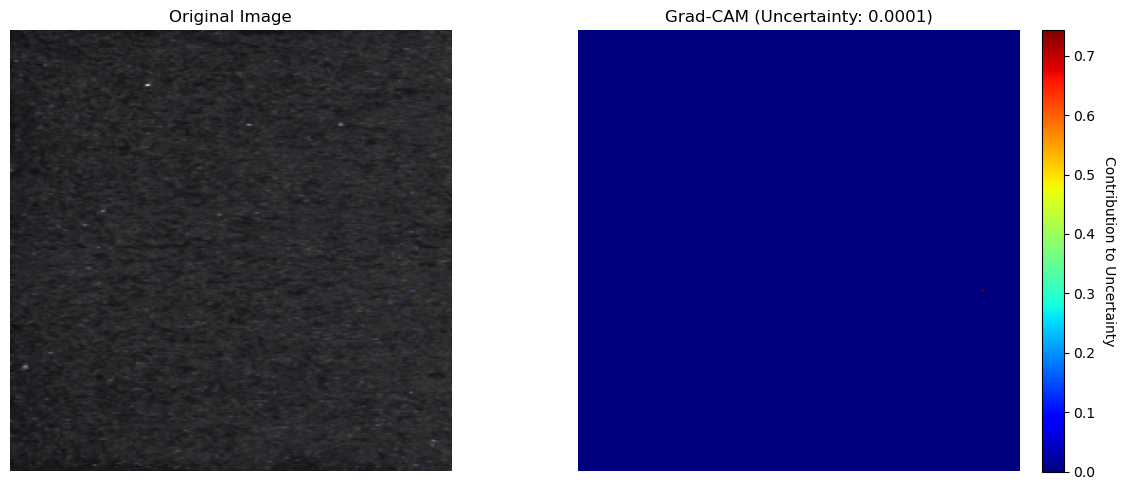

Selected 50 samples for labeling.


100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [01:58<00:00,  1.01it/s]


Iteration 15, Epoch 1/2 - Train Loss: 0.2622


100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [01:59<00:00,  1.01it/s]


Iteration 15, Epoch 2/2 - Train Loss: 0.2252


In [18]:
al_model = active_learning_loop(al_model_initial,  labeled_df=train_df_labelled, unlabeled_df=train_df_unlabelled,
                                budget_per_iter=al_budget_per_iter, max_iterations=al_max_iterations, 
                                epochs_per_iter=al_epochs_per_iter, n_show=al_n_show)

model_save_path_al = f"./{base_dir}/model/al_model.pt"
torch.save(al_model.state_dict(), model_save_path_al)

In [19]:
active_learning_metrics = evaluate_metrics(testloader, al_model)

100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:22<00:00,  2.81it/s]


Model Evaluation Metrics:
------------------------------
Metric            Value
------------------------------
IoU              0.6274
Dice             0.7268
Accuracy         0.9986
Precision        0.8595
Recall           0.7337
------------------------------


In [29]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

log_file_path = f"./{base_dir}/results/training_log.txt"

with open(log_file_path, 'a') as log_file:  
    log_file.write(f"\nRun at {timestamp}\n")
    log_file.write("========================================\n\n")
    
    # Hyperparameters
    log_file.write("Hyperparameters:\n")
    log_file.write(f"Device: {DEVICE}\n")
    log_file.write(f"Learning Rate (LR): {LR}\n")
    log_file.write(f"Image Size: {IMAGE_SIZE}\n")
    log_file.write(f"Batch Size: {BATCH_SIZE}\n")
    log_file.write(f"Encoder: {ENCODER}\n")
    log_file.write(f"Weights: {WEIGHTS}\n")
    log_file.write(f"Baseline Epochs (EPOCHS): {EPOCHS}\n")
    log_file.write(f"Initial Active Learning Epochs (EPOCHS_AL_INITIAL): {EPOCHS_AL_INITIAL}\n")
    log_file.write(f"Active Learning Budget per Iteration: {al_budget_per_iter}\n")
    log_file.write(f"Active Learning Max Iterations: {al_max_iterations}\n")
    log_file.write(f"Active Learning Epochs per Iteration: {al_epochs_per_iter}\n")
    log_file.write(f"Active Learning N Show: {al_n_show}\n\n")
    
    # Data Split
    log_file.write("Data Split:\n")
    log_file.write(f"Total Training Data: {len(df_train_full)}\n")
    log_file.write(f"Labeled Training Data: {len(train_df_labelled)} (50% split)\n")
    log_file.write(f"Unlabeled Training Data: {len(train_df_unlabelled)} (50% split)\n")
    log_file.write(f"Test Data: {len(test_df)}\n\n")
    
    # Training Losses
    log_file.write("Training Losses:\n")
    log_file.write("Baseline Model Losses per Epoch:\n")
    for i, loss in enumerate(train_losses_baseline):
        log_file.write(f"Epoch {i+1}: {loss:.4f}\n")
    log_file.write("Initial Active Learning Model Losses per Epoch:\n")
    for i, loss in enumerate(train_losses_al_initial):
        log_file.write(f"Epoch {i+1}: {loss:.4f}\n")
    log_file.write("\n")
    
    # Metrics
    log_file.write("Evaluation Metrics:\n")
    log_file.write("Baseline Model:\n")
    for metric_name, value in baseline_metrics.items():
        log_file.write(f"{metric_name}: {value:.4f}\n")
    log_file.write("Active Learning Model:\n")
    for metric_name, value in active_learning_metrics.items():
        log_file.write(f"{metric_name}: {value:.4f}\n")
    log_file.write("\n")  # Extra newline for separation between runs

print(f"Log file updated at: {log_file_path}")

NameError: name 'al_n_show' is not defined